In [2]:
import pandas as pd
import numpy as np
import datetime
import copy
import matplotlib.pyplot as plt
import datetime as dt
import yfinance as yf

## Utility Functions

We'll be working with monthly data since this is a long term investing strategy. So the KPIs are adjusted accordingly to take in monthly data.

In [3]:
def CAGR(DF):
    df=DF.copy()
    df['cum_return']=(1+df['mon_ret']).cumprod()
    n = len(df)/12
    CAGR = (df['cum_return'].iloc[-1])**(1/n) - 1
    return CAGR

def volatility(DF):
    df = DF.copy()
    vol = df['mon_ret'].std()*np.sqrt(12)
    return vol

def sharpe(DF,rf):
    df = DF.copy()
    return (CAGR(df)-rf)/volatility(df)

def max_dd(DF):
    df=DF.copy()
    df['cum_return'] = (1+df['mon_ret']).cumprod()
    df['cum_roll_max'] = df['cum_return'].cummax()
    df['drawdown'] = df['cum_roll_max'] - df['cum_return']
    return (df['drawdown']/df['cum_roll_max']).max()

## Getting DJI constituent stocks data from 10 years ago


Getting all the stocks present in 2014 in the Dow Jones Index and using yfinance to gather monthly data from the last 10 years.

In [4]:
tickers = ["MMM","AXP","T","BA","CAT","CSCO","KO", "XOM","GE","GS","HD",
           "IBM","INTC","JNJ","JPM","MCD","MRK","MSFT","NKE","PFE","PG","TRV",
           "UNH","VZ","V","WMT","DIS"]

In [5]:
# Calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_mon = {} # directory with ohlc value for each stock            
start = dt.datetime.today()-dt.timedelta(3650)
end = dt.datetime.today()

# looping over tickers and creating a dataframe with close prices
for ticker in tickers:
    ohlc_mon[ticker] = yf.download(ticker,start,end,interval='1mo')
    ohlc_mon[ticker].dropna(inplace=True,how="all")
 
tickers = ohlc_mon.keys() # redefine tickers variable after removing any tickers with corrupted data

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

## Backtesting

After copying our dataset (which we should always do) we make a function that takes in the dataframe, number of stocks you want in your portfolio and the number of underperforming stocks to be removed each month from the portfolio. The latter two are hyperparameters which can be fined tuned to maximise the returns of the portfolio.

In [6]:
# calculating monthly return for each stock and consolidating return info by stock in a separate dataframe
ohlc_dict = copy.deepcopy(ohlc_mon)
return_df = pd.DataFrame()
for ticker in tickers:
    ohlc_dict[ticker]["mon_ret"] = ohlc_dict[ticker]["Adj Close"].pct_change()
    return_df[ticker] = ohlc_dict[ticker]["mon_ret"]
return_df.dropna(inplace=True)

In [7]:
# function to calculate portfolio return iteratively
def pflio(DF,m,x):
    """Returns cumulative portfolio return
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be removed from portfolio monthly"""
    df = DF.copy()
    portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(portfolio) > 0:
            monthly_ret.append(df[portfolio].iloc[i,:].mean())
            bad_stocks = df[portfolio].iloc[i,:].sort_values(ascending=True)[:x].index.values.tolist()
            portfolio = [t for t in portfolio if t not in bad_stocks]
        fill = m - len(portfolio)
        new_picks = df.iloc[i,:].sort_values(ascending=False)[:fill].index.values.tolist()
        portfolio = portfolio + new_picks
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret),columns=["mon_ret"])
    return monthly_ret_df

## Calculating overall strategy's KPIs

In [8]:
#calculating overall strategy's KPIs
print("CAGR for the portfolio is ",CAGR(pflio(return_df,6,3)))
print("Sharpe Ratio for the portfolio is ",sharpe(pflio(return_df,6,3),0.025))
print("Max Drawdown for the portfolio was ",max_dd(pflio(return_df,6,3))) 

CAGR for the portfolio is  0.1215908182733072
Sharpe Ratio for the portfolio is  0.5689403591891782
Max Drawdown for the portfolio was  0.270127404572566


## Calculating KPIs for index buy and hold startegy for the same period

In [9]:
dji = yf.download("^DJI",start,end, interval = '1mo')
dji['mon_ret']=dji["Adj Close"].pct_change()
print("CAGR for DJI was ",CAGR(dji))
print("Sharpe Ratio for DJI was ",sharpe(dji,0.025))
print("Max Drawdown for DJI was ",max_dd(dji)) 

[*********************100%%**********************]  1 of 1 completed

CAGR for DJI was  0.08678631081475796
Sharpe Ratio for DJI was  0.4050382038508618
Max Drawdown for DJI was  0.23201266165063428


## Visualisation and Results

1 dollar invested in this strategy in 2014 woud be  3.1202657432365575  dollars
1 dollar invested in Dow Jones Index in 2014 woud be  2.2984845771187046  dollars


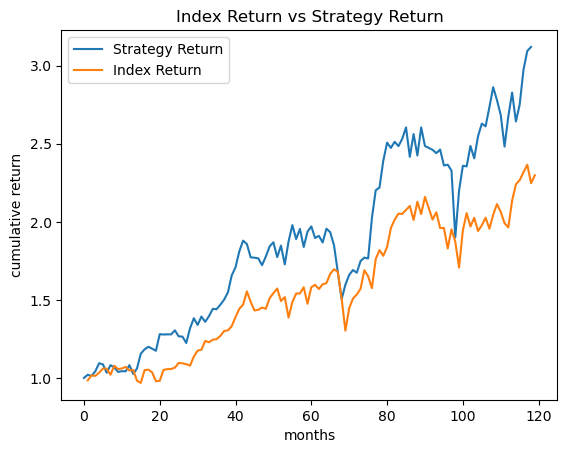

In [10]:
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+dji["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Strategy Return")
plt.ylabel("cumulative return")
plt.xlabel("months")
ax.legend(["Strategy Return","Index Return"])
print("1 dollar invested in this strategy in 2014 woud be ",(1 + pflio(return_df,6,3)['mon_ret']).cumprod().iloc[-1]," dollars")
print("1 dollar invested in Dow Jones Index in 2014 woud be ",(1 + dji['mon_ret']).cumprod().iloc[-1]," dollars")

Some obvious inferences we can draw from this strategy are :
1. We have picked unique stocks every month, ie. we didn't double down on the outperforming stocks. Penalising the best stocks for the month for just being outperforming the market and not doubling them helps with the diversification and volatility of the startegy but also makes us lose on potential profits.
2. It is also obvious that in a ranging market we can expect slower returns than usual. So this strategy works best in a bullish trending market.
3. We also only select the universe of stocks in our portfolio which were present in Dow Jones Index in 2014, ie the start of our backtesting period and completely ignore the fact that the constituent stocks of an index fund can change or get delisted with time.
4. This startegy only incorporates buying (going long) on a particular number of best stocks in a best month. So it might be obvious that it will perform better in  a bullish market than a bearish market. We can verify this assumption throught the above chart. We were in a bearish market from Jan to Mar of 2020, because of the world shutting down due to COVID and we can see that our portfolio tanked along with the Dow Jones Index. In india we can only hold short positions intraday in the spot market, so there's no point in shorting for a longer period of time than a day but we'll still make a strategy that takes into account shorting stocks.

## Incorporating shorting the worst stocks

This function has the capability to short the worst-performing stocks by taking their negative tickers in the portfolio list, effectively creating short positions for those stocks. We also have to tweak the monthly returns to take into account the short return.

In [62]:
# function to calculate portfolio return iteratively
def pflio_short(DF, m, x):
    """
    Returns cumulative portfolio return with shorting capability
    DF = dataframe with monthly return info for all stocks
    m = number of stock in the portfolio
    x = number of underperforming stocks to be shorted from portfolio monthly
    """
    df = DF.copy()
    short_portfolio = []
    monthly_ret = [0]
    for i in range(len(df)):
        if len(short_portfolio) > 0:
            monthly_ret.append(df[short_portfolio].iloc[i, :].mean())
            #bad_stocks = df[portfolio].iloc[i, :].sort_values(ascending=True)[:x].index.values.tolist()
            #portfolio = [t for t in portfolio if t not in bad_stocks]
            good_stocks = df[short_portfolio].iloc[i, :].sort_values(ascending=False)[:x].index.values.tolist()
            short_portfolio = [t for t in short_portfolio if t not in good_stocks]
        fill = m - len(short_portfolio)
        new_picks = df.iloc[i, :].sort_values(ascending=False)[:fill].index.values.tolist()
        short_portfolio = short_portfolio + new_picks
    # Adjust monthly returns for short positions
    monthly_ret_adjusted = monthly_ret.copy()
    for i in range(1, len(monthly_ret)):
        short_return = df[short_portfolio].iloc[i, :].mean()
        monthly_ret_adjusted[i] -= short_return
    monthly_ret_df = pd.DataFrame(np.array(monthly_ret_adjusted), columns=["mon_ret"])
    return monthly_ret_df

In [63]:
#calculating overall strategy's KPIs
print("CAGR for the portfolio is ",CAGR(pflio_short(return_df,6,3)))
print("Sharpe Ratio for the portfolio is ",sharpe(pflio_short(return_df,6,3),0.025))
print("Max Drawdown for the portfolio was ",max_dd(pflio_short(return_df,6,3))) 

CAGR for the portfolio is  -0.0024891137099640748
Sharpe Ratio for the portfolio is  -0.3235448231884293
Max Drawdown for the portfolio was  0.2600664929527968


1 dollar invested in the long strategy in 2014 woud be  2.725258896588137  dollars
1 dollar invested in the short strategy in 2014 woud be  0.975588420017383  dollars
1 dollar invested in Dow Jones Index in 2014 woud be  2.2984845771187046  dollars


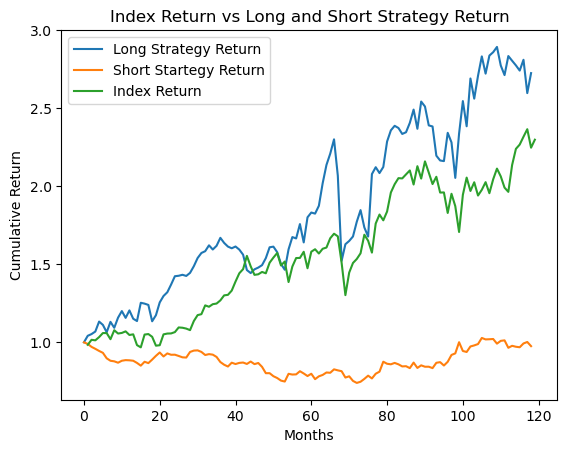

In [72]:
fig, ax = plt.subplots()
plt.plot((1+pflio(return_df,6,3)).cumprod())
plt.plot((1+pflio_short(return_df,6,3)).cumprod())
plt.plot((1+dji["mon_ret"].reset_index(drop=True)).cumprod())
plt.title("Index Return vs Long and Short Strategy Return")
plt.ylabel("Cumulative Return")
plt.xlabel("Months")
ax.legend(["Long Strategy Return","Short Startegy Return","Index Return"])
print("1 dollar invested in the long strategy in 2014 woud be ",(1 + pflio(return_df,6,3)['mon_ret']).cumprod().iloc[-1]," dollars")
print("1 dollar invested in the short strategy in 2014 woud be ",(1 + pflio_short(return_df,6,3)['mon_ret']).cumprod().iloc[-1]," dollars")
print("1 dollar invested in Dow Jones Index in 2014 woud be ",(1 + dji['mon_ret']).cumprod().iloc[-1]," dollars")

We see that the shorting strategy significantly underperformed when compared to both the Long Strategy and just the simple Index Buy and Hold. This is expected as shorting stocks in the longer run is not a good idea, since good companies (stocks) will tend to rise up in value in the longer run even if they pullback in the short term during a bear market. We would have actually lost some money if we were to be bearish and keep on shorting stocks.